In [1]:
# Preprocess Images with opencv2
import cv2
import numpy as np
import matplotlib.pyplot as plt

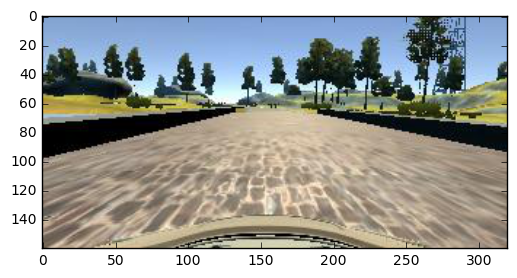

In [2]:
# Preprocess Images with opencv2
from IPython import get_ipython
import matplotlib.image as mpimg
#%matplotlib inline
 
# load the image and show it
#reading in an image
image = mpimg.imread("data\IMG\center_2016_12_01_13_30_48_287.jpg")
plt.imshow(image)

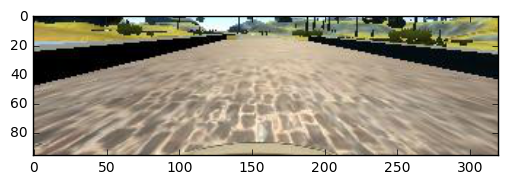

In [3]:
image_crop = image[50:50+96]
#print(image_crop.shape[0])
plt.imshow(image_crop)

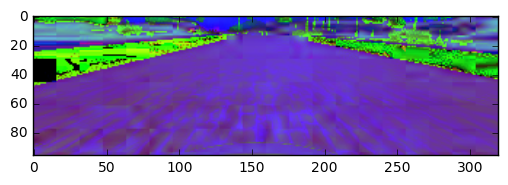

In [4]:
def convert_to_hsv(img):
        """
        return HSV version of image
        """
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

image_crop_hsv = convert_to_hsv(image_crop)
plt.imshow(image_crop_hsv)

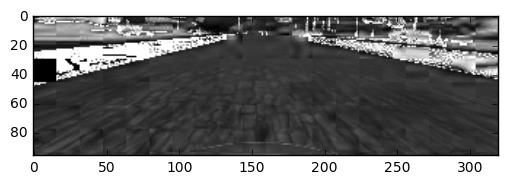

In [5]:
def hsv_value(img):
        """
        return saturation channel of HSV color space
        """
        return img[:, :, 1]

image_crop_hsv_s = hsv_value(image_crop_hsv)
plt.imshow(image_crop_hsv_s, cmap='gray')

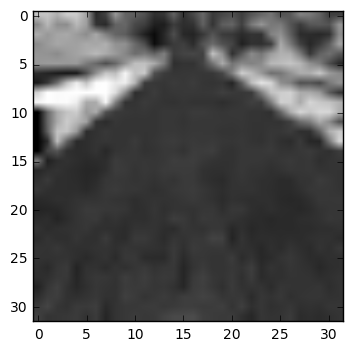

In [6]:
# resize
image_crop_hsv_s_square = cv2.resize(image_crop_hsv_s, (32,32), interpolation = cv2.INTER_AREA)
plt.imshow(image_crop_hsv_s_square, cmap='gray')

In [7]:
# image samples look good, so create a function to do the processing in one step
rows = 32
columns = 32
crop_y = 50
crop_y_length = 3*32

def process(image):
    image = cv2.resize((cv2.cvtColor(image[crop_y:crop_y+crop_y_length],
                                     cv2.COLOR_RGB2HSV))[:,:,1],
                       (columns, rows),
                       interpolation = cv2.INTER_AREA)
    return image

In [8]:
import csv

driving_log = []

with open('data\driving_log.csv', 'r') as f:
    reader = csv.reader(f, skipinitialspace=True)
    next(reader, None)  # skip over header row
    for row in reader:
        driving_log.append(row)

(160, 320, 3)
(32, 32)


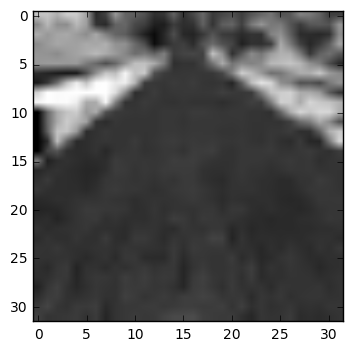

In [9]:
#reading in an image
image = mpimg.imread("data\IMG\center_2016_12_01_13_30_48_287.jpg")
print(image.shape)
processed_image = process(image)
print(processed_image.shape)
plt.imshow(processed_image, cmap='gray')

In [10]:
# assume constant csv header, 0 - center, 1 - left, 2 - right, 3 - steering angle
center = 0
left = 1
right = 2
steering_angle = 3
steering_adjustment = 0.325

# initialize lists
image_data = []
steering_data = []

# iterate through driving_log and add processed images to a list, numpy arrays are too slow for this
for n in range(len(driving_log)):
    # Process and save left image and calculated angle
    image_data.append(process(plt.imread('data\\'+driving_log[n][left])))
    steering_data.append(float(driving_log[n][steering_angle]) + steering_adjustment)
    # Process and save center image and angle
    image_data.append(process(plt.imread('data\\'+driving_log[n][center])))
    steering_data.append(float(driving_log[n][steering_angle]))
    # Process and save right image and calculated angle
    image_data.append(process(plt.imread('data\\'+driving_log[n][right])))
    steering_data.append(float(driving_log[n][steering_angle]) - steering_adjustment)

# copy over data to numpy arrays
X_train = np.array(image_data).astype('float32')
y_train = np.array(steering_data).astype('float32')

In [11]:
# flip images
X_train = np.append(X_train, np.fliplr(X_train), axis = 0)
# flip steering angles
y_train = np.append(y_train, -y_train, axis = 0)

In [12]:
# reshape to prepare for model
X_train = X_train.reshape(X_train.shape[0], rows, columns, 1)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, random_state = 0, test_size = 0.175)

In [14]:
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam

model = Sequential()

# 1st Layer - for pixel value normalization alla Comma.ai
model.add(Lambda(lambda x: x/127.5 - 1., input_shape = (rows, columns, 1)))

# 2nd Layer - convolution 2d layer
model.add(Conv2D(16, 3, 3, border_mode = 'valid', input_shape = (rows, columns, 1), activation = 'relu'))

# 3rd Layer - pooling
model.add(MaxPooling2D((4,4), (4,4), 'valid'))

# 4th Layer - dropout
model.add(Dropout(0.3))

# 5th Layer - flater
model.add(Flatten())

# 6th Layer - dense
model.add(Dense(1))

model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 32, 32, 1)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 30, 30, 16)    160         lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 7, 7, 16)      0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 7, 7, 16)      0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [15]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
history = model.fit(X_train, y_train, batch_size = 128, nb_epoch = 10, verbose = 1, validation_data = (X_validate, y_validate))

Train on 39778 samples, validate on 8438 samples
Epoch 1/10
39778/39778 [==============================] - 2s - loss: 0.0580 - val_loss: 0.0387
Epoch 2/10
39778/39778 [==============================] - 1s - loss: 0.0411 - val_loss: 0.0361
Epoch 3/10
39778/39778 [==============================] - 1s - loss: 0.0384 - val_loss: 0.0342
Epoch 4/10
39778/39778 [==============================] - 1s - loss: 0.0367 - val_loss: 0.0329
Epoch 5/10
39778/39778 [==============================] - 1s - loss: 0.0356 - val_loss: 0.0317
Epoch 6/10
39778/39778 [==============================] - 1s - loss: 0.0346 - val_loss: 0.0311
Epoch 7/10
39778/39778 [==============================] - 1s - loss: 0.0336 - val_loss: 0.0306
Epoch 8/10
39778/39778 [==============================] - 1s - loss: 0.0332 - val_loss: 0.0316
Epoch 9/10
39778/39778 [==============================] - 1s - loss: 0.0322 - val_loss: 0.0289
Epoch 10/10
39778/39778 [==============================] - 1s - loss: 0.0319 - val_loss: 0.0287


In [16]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Model saved.")

Model saved.
